In [3]:
# Load Dataset
import pandas as pd
import json
import numpy as np
FILE_PATH = "./data/"
FILE_NAME = "log2.json"
# dataDictList is a list of dicts
with open(FILE_PATH+FILE_NAME, 'r') as f:
    dataDictList = json.load(f)



In [4]:
# Global constants

PARTS =  {"nose" : 0, 
  "leftEye" : 1, 
  "rightEye" : 2, 
  "leftEar" : 3, 
  "rightEar" : 4, 
  "leftShoulder" : 5, 
  "rightShoulder" : 6, 
  "leftElbow" : 7, 
  "rightElbow" : 8, 
  "leftWrist" : 9, 
  "rightWrist" : 10, 
  "leftHip" : 11, 
  "rightHip" : 12, 
  "leftKnee" : 13, 
  "rightKnee" : 14, 
  "leftAnkle" : 15, 
  "rightAnkle" : 16}

requiredParts = ["nose", 
#   "leftEye", 
#   "rightEye", 
#   "leftEar", 
#   "rightEar", 
  "leftShoulder", 
  "rightShoulder", 
#   "leftElbow", 
#   "rightElbow", 
#   "leftWrist", 
#   "rightWrist", 
  "leftHip", 
  "rightHip", 
  "leftKnee", 
  "rightKnee", 
  "leftAnkle", 
  "rightAnkle"
]

IMAGE_X_SIZE = 600
IMAGE_Y_SIZE = 450
len(dataDictList[0]['keypoints'])

17

In [5]:
# Generate List that we want


def genList(dataDictList, requiredParts, startIndex, stopIndex):
    '''
    @args
    dataDictList - json load
    requiredParts - ["nose", etc.]
    startIndex - relative timestamp to start. 0
    stopIndex - relative timestamp to stop. len(dataDictList)
    @returns
    [#, x], [#, y]
    '''
    dataListX = None
    dataListY = None
    for _frame in range(startIndex, stopIndex):
        if dataListX is None:
            print(_frame)
            dataListX = [[dataDictList[_frame]['keypoints'][PARTS[X]]['position']['x'] for X in requiredParts]]
            dataListY = [[dataDictList[_frame]['keypoints'][PARTS[X]]['position']['y'] for X in requiredParts]]
        else:
            dataListX = dataListX + [[dataDictList[_frame]['keypoints'][PARTS[_part]]['position']['x'] for _part in requiredParts]]
            dataListY = dataListY + [[dataDictList[_frame]['keypoints'][PARTS[_part]]['position']['y'] for _part in requiredParts]]
    
    dataListX = np.array(dataListX) # [[x]]
    dataListY = np.array(dataListY) # [[y]]
    print("Generated lists of shape:", dataListX.shape, dataListY.shape)
    newDataListX = np.reshape(dataListX, (-1,len(requiredParts))) 
    newDataListY = np.reshape(dataListY, (-1,len(requiredParts))) #[#instance, (y) for each keypoint]
    print("Reshaped to:", newDataListX.shape, newDataListY.shape)
    return newDataListX, newDataListY


newDataListX, newDataListY = genList(dataDictList, requiredParts, 0, len(dataDictList))


0
Generated lists of shape: (116, 9) (116, 9)
Reshaped to: (116, 9) (116, 9)


In [6]:
# Normalization
'''
 This has 2 parts-
 Resize, by identifying and scaling as bounding box, and then (Min-Max) Normalize
 Note: The broadcasting here is element-wise. 
 Sources:
 [1] https://medium.com/tensorflow/move-mirror-an-ai-experiment-with-pose-estimation-in-the-browser-using-tensorflow-js-2f7b769f9b23
 [2] https://raw.githubusercontent.com/paulvollmer/posenet-keypoints-normalization/master/src/index.js
 

''' 

def scale(newDataListX, newDataListY):
    '''
    Assumes dataList of form [#instance, [(x,y) for each keypoint]]
    Possible optim: bounding box wont change much across frames
    '''
    # Bounding Box
    maxX = np.max(newDataListX, axis=1)
    minX = np.min(newDataListX, axis=1)
    maxY = np.max(newDataListY, axis=1)
    minY = np.min(newDataListY, axis=1)
    assert(len(minY)==len(newDataListX))
    l2Data = np.concatenate((newDataListX, newDataListY), axis=1)
    print(l2Data.shape)
    # Reset to Origin and Scale
    for _data in range(0, len(newDataListX)):
        l2Data[_data] = l2Data[_data] / np.linalg.norm(l2Data[_data]) # L2 norm if the need be
    return l2Data[:,:newDataListX.shape[-1]], l2Data[:,newDataListY.shape[-1]:]

scaledDataX, scaledDataY = scale(newDataListX, newDataListY)


x_key=pd.DataFrame(scaledDataX)
y_key=pd.DataFrame(scaledDataY)
x_key.columns=requiredParts
y_key.columns=requiredParts
keydoc=FILE_NAME[:-5]
x_key.to_csv(FILE_PATH+keydoc+"_x.csv")
y_key.to_csv(FILE_PATH+keydoc+"_y.csv")

(116, 18)


In [7]:
x_key

,nose,leftShoulder,rightShoulder,leftHip,rightHip,leftKnee,rightKnee,leftAnkle,rightAnkle
0,0.255213,0.179377,0.359127,0.196306,0.330280,0.173657,0.251916,0.255154,0.240770
1,0.303797,0.323078,0.318090,0.320351,0.343801,0.337682,0.293264,0.300202,0.300797
2,0.283460,0.325824,0.324202,0.384308,0.353464,0.286975,0.278107,0.313504,0.313955
3,0.249672,0.350134,0.343929,0.320515,0.266701,0.349892,0.358064,0.300355,0.363396
4,0.239298,0.341554,0.246041,0.332044,0.268676,0.338719,0.191726,0.339461,0.196474
...,...,...,...,...,...,...,...,...,...
111,0.232920,0.194905,0.277807,0.208565,0.268370,0.472296,0.292970,0.183274,0.184283
112,0.220967,0.183188,0.264431,0.198377,0.251928,0.450508,0.448944,0.173596,0.172624
113,0.245926,0.204008,0.290274,0.222750,0.273745,0.200020,0.487825,0.189281,0.188444
114,0.266845,0.220854,0.314962,0.240407,0.290538,0.216209,0.313197,0.203408,0.201966


In [92]:
# Choose if you want to plot X or Y

<IPython.core.display.Javascript object>


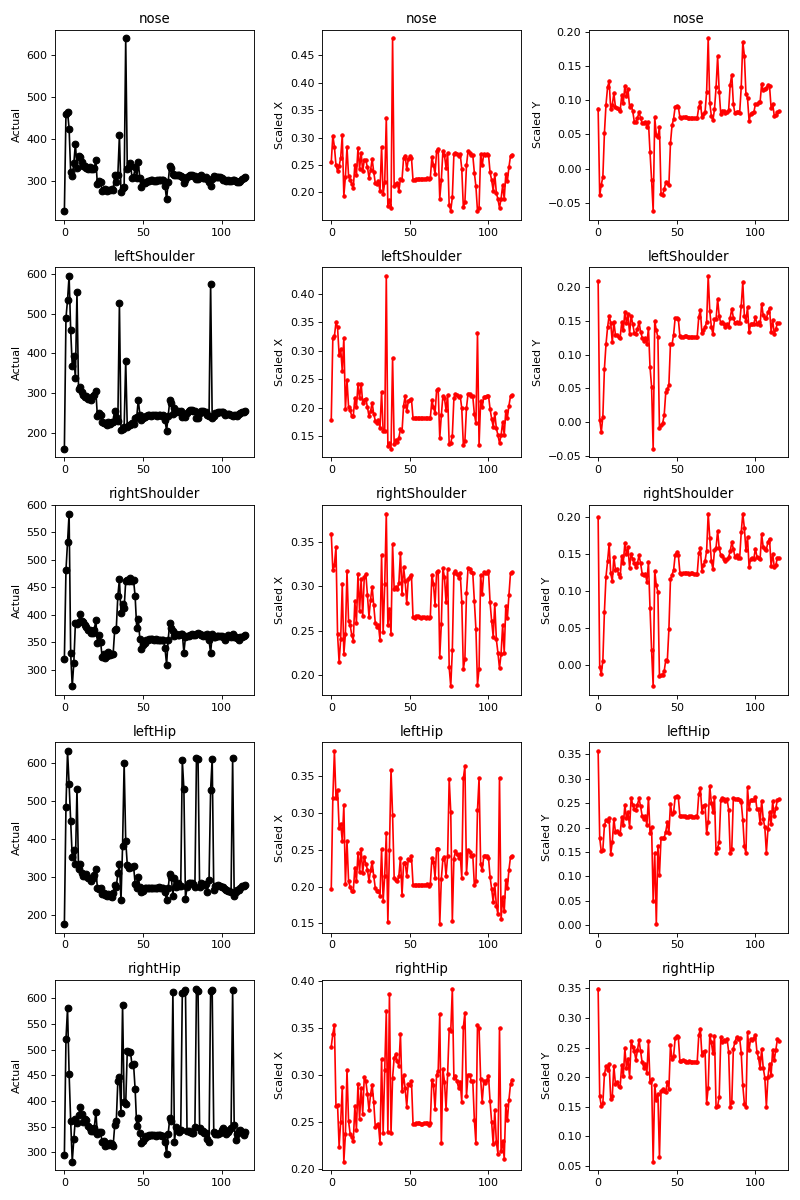

In [93]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10, 15), dpi= 80, facecolor='w', edgecolor='k')
num_graphs = 5
index = 0
for sub in range(0, num_graphs, 1):
    plt.subplot(5, 3, 3*sub+1)
    plt.plot(newDataListX[:,index], 'ko-')
    plt.title(requiredParts[index])
    plt.ylabel('Actual')

    plt.subplot(5, 3, 3*sub+2)
    plt.plot(scaledDataX[:,index],  'r.-')
    plt.title(requiredParts[index])
    plt.ylabel('Scaled X')
    
    plt.subplot(5, 3, 3*sub+3)
    plt.plot(scaledDataY[:,index],  'r.-')
    plt.title(requiredParts[index])
    plt.ylabel('Scaled Y')
    index = index + 1

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


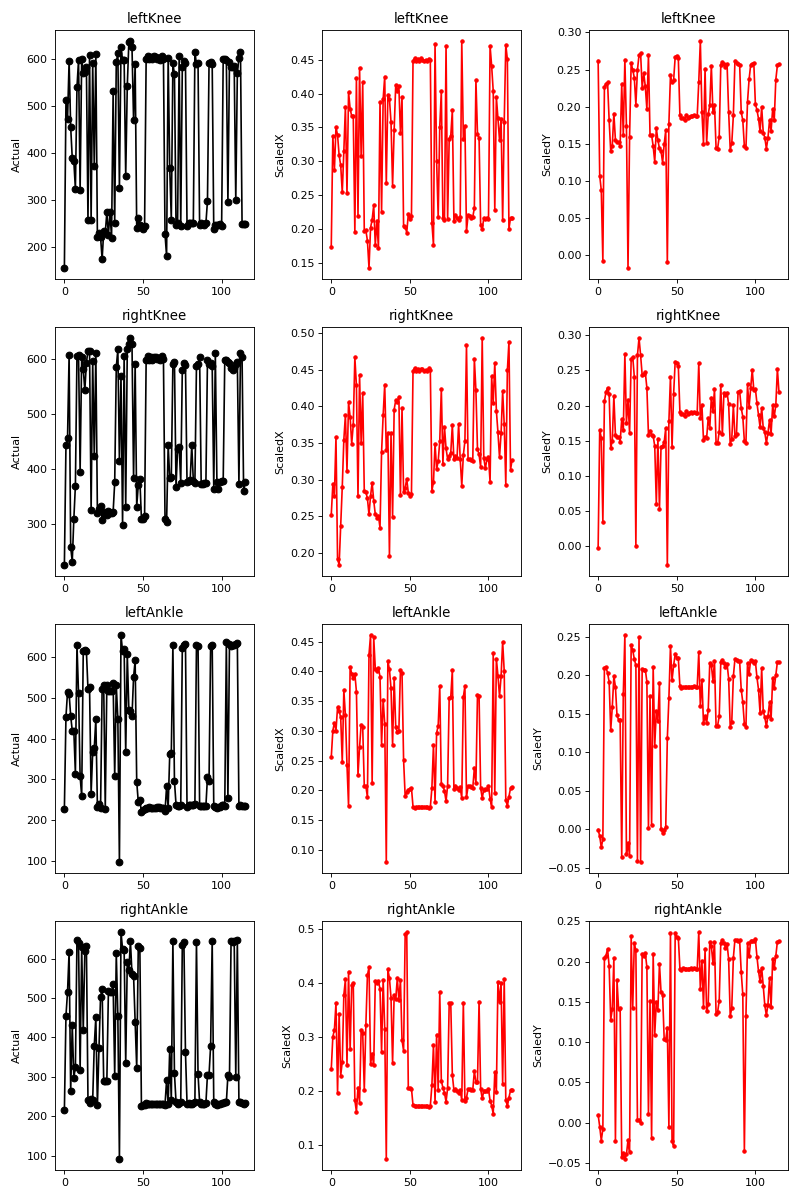

In [94]:
index=5
fig=plt.figure(figsize=(10, 15), dpi= 80, facecolor='w', edgecolor='k')
for sub in range(0, 4, 1):
    plt.subplot(4, 3, 3*sub+1)
    plt.plot(newDataListX[:,index], 'ko-')
    plt.title(requiredParts[index])
    plt.ylabel('Actual')
    plt.subplot(4, 3, 3*sub+2)
    plt.plot(scaledDataX[:,index],  'r.-')
    plt.title(requiredParts[index])
    plt.ylabel('ScaledX')
    plt.subplot(4, 3, 3*sub+3)
    plt.plot(scaledDataY[:,index],  'r.-')
    plt.title(requiredParts[index])
    plt.ylabel('ScaledY')
    index = index+1
    
plt.tight_layout()
plt.show()

In [45]:
# fig=plt.figure(figsize=(10, 15), dpi= 80, facecolor='w', edgecolor='k')
# for sub in range(0, 4, 1):
#     plt.subplot(5, 3, (3*sub+1))
#     plt.plot(newDataListX[:,index], 'ko-')
#     plt.title(requiredParts[index])
#     plt.ylabel('Actual')
#     plt.subplot(5, 3, (3*sub+2))
#     plt.plot(scaledDataX[:,index],  'r.-')
#     plt.title(requiredParts[index])
#     plt.ylabel('ScaledX')
#     plt.subplot(5, 3, (3*sub+3))
#     plt.plot(scaledDataY[:,index],  'r.-')
#     plt.title(requiredParts[index])
#     plt.ylabel('ScaledY')
#     index = index+1
    
# plt.tight_layout()
# plt.show()

<IPython.core.display.Javascript object>


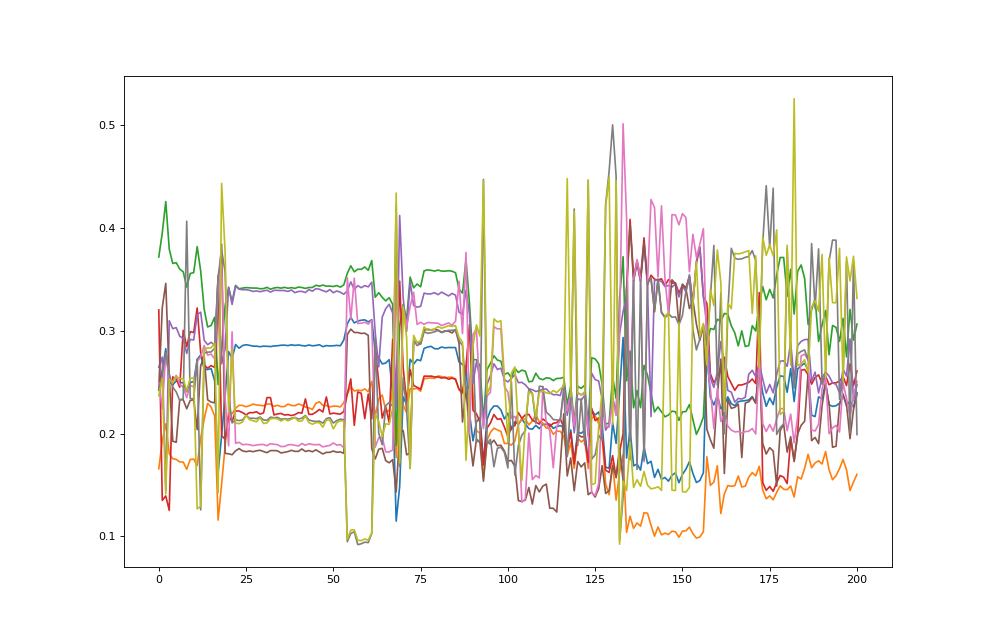

In [72]:
fig=plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x_key);